# Sensitivity of optimistic NPG primal-dual for finite constrained MDPs

In [1]:
'''
Set-up:
1) Softmax policy 
2) Bounded rewards
3) Many states and actions
4) (Natural) policy gradient + optimistic primal-dual method (OMWU version)
   (Natural) policy gradient + optimistic primal-dual method (ReLOAD version)
   
References:
1) ReLOAD  
   ReLOAD: Reinforcement Learning with Optimistic Ascent-Descent for Last-Iterate Convergence in Constrained MDPs
   arXiv:2302.01275v2 
'''

'\nSet-up:\n1) Softmax policy \n2) Bounded rewards\n3) Many states and actions\n4) (Natural) policy gradient + optimistic primal-dual method (OMWU version)\n   (Natural) policy gradient + optimistic primal-dual method (ReLOAD version)\n   \nReferences:\n1) ReLOAD  \n   ReLOAD: Reinforcement Learning with Optimistic Ascent-Descent for Last-Iterate Convergence in Constrained MDPs\n   arXiv:2302.01275v2 \n'

In [2]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [3]:
## Random Seed
np.random.seed(10) 
## Problem Setup
gamma = 0.9
n, m = 20, 5 # s, a
'''
Randomly generated probability transition matrix P((s,a) -> s') in R^{|S||A| x |S|}
Each row sums up to one
'''
raw_transition = np.random.uniform(0,1,size=(n*m,n))
prob_transition = raw_transition/raw_transition.sum(axis=1,keepdims=1)
'''
Random positive rewards
'''
reward = np.random.uniform(0,1,size=(n*m))

'''
Random utilities between -1 and +1
'''
utility = np.random.uniform(-1,1,size=(n*m))

'''
Start state distribution
'''
# uniform
rho = np.ones(n)/n


In [4]:
"""
Input: Discrete probability distributions p, q : array-like, dtype=float, shape=n
Output: Kullback-Leibler divergence D(p||q)      
"""
def kl_div(p, q):
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)
    
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [5]:
'''
Input: theta as an array and 
Output: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        for j in range(m*i,m*(i+1)):
            prob.append(np.exp(theta[j])/norm)
            
    return np.asarray(prob)

In [6]:
'''
Input: theta as an array and 
Output: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy_naive(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(theta[m*i:m*(i+1)])
        for j in range(m*i,m*(i+1)):
            prob.append(theta[j]/norm)
            
    return np.asarray(prob)

In [7]:
"""
License: BSD
Author: Mathieu Blondel
Implements three algorithms for projecting a vector onto the simplex: sort, pivot and bisection.
For details and references, see the following paper:
Large-scale Multiclass Support Vector Machine Training via Euclidean Projection onto the Simplex
Mathieu Blondel, Akinori Fujino, and Naonori Ueda.
ICPR 2014.
http://www.mblondel.org/publications/mblondel-icpr2014.pdf
"""

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_bisection(v, z=1, tau=0.0001, max_iter=1000):
    func = lambda x: np.sum(np.maximum(v - x, 0)) - z
    lower = np.min(v) - z / len(v)
    upper = np.max(v)

    for it in range(max_iter):
        midpoint = (upper + lower) / 2.0
        value = func(midpoint)

        if abs(value) <= tau:
            break

        if value <= 0:
            upper = midpoint
        else:
            lower = midpoint

    return np.maximum(v - midpoint, 0)

# if __name__ == '__main__':
#     v = np.array([1.1, 0.2, 0.2])
#     z = 1

#     w = projection_simplex_sort(v, z)
#     print(np.sum(w))
#     print(w)

#     w = projection_simplex_pivot(v, z)
#     print(np.sum(w))
#     print(w)

#     w = projection_simplex_bisection(v, z)
#     print(np.sum(w))
#     print(w)

In [8]:
'''
Input: theta as an array and 
Output: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def project_to_policy(theta,n,m):
    prob = []
    prob_pers = []
    for i in range(n):
#         norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        prob_pers = projection_simplex_sort(theta[m*i:m*(i+1)], z=1)
        for j in range(m):
            prob.append(prob_pers[j])
            
    return np.asarray(prob)

In [9]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|S| x |S||A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n,n*m))
    for i in range(n):
        Pi[i,i*m:(i+1)*m] = prob[i*m:(i+1)*m]
    
    return Pi

In [10]:
'''
Input: probability vector, state, action
Output: \nabla_{\theta} \pi_{\theta}(s,a)

States go from 0 to n-1 and actons from 0 to m-1
'''
def grad_state_action(prob,state,action):
    grad = np.zeros(n*m)
    for j in range(0,m):
        if j == action:
            grad[m*state + j] = prob[m*state + j]*(1-prob[m*state + j])
        else:
            grad[m*state + j] = -prob[m*state + action]*prob[m*state + j]
            
    return grad

def grad_state(qvals,prob,state):
    grad = np.sum([qvals[state*m + i]*grad_state_action(prob,state,i) for i in range(0,m)],axis=0)
    return grad

def grad(qvals,prob,d_pi):
    grad = np.sum([d_pi[i]*grad_state(qvals,prob,i) for i in range(0,n)],axis=0)
    return grad

In [11]:
'''
Input: probability vector
Output: Fisher information matrix
        \nabla_{\theta} \pi_{\theta}(s,a) x {\nabla_{\theta} \pi_{\theta}(s,a)}^T
'''
def Fisher_info(prob,d_pi):
    qvals_one = np.ones(n*m)
    grad = np.sum([d_pi[i]*grad_state(qvals_one,prob,i) for i in range(0,n)],axis=0)
    fisher = np.outer(grad,grad)+1e-3*np.identity(n*m)
    return fisher

In [12]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])
    
    ell = np.dot(V,rho)
    return ell

In [13]:
'''
The overall reward advantage function \ell(\theta)
'''
def avals(qvals,prob):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])
    
    A = qvals
    for i in range(n):
        for j in range(m):
            A[i*m + j] = qvals[i*m + j] - V[i]
        
    return A

In [14]:
'''
The projection function
Input: a scalar 
Output: a scalar in the interval [0 C]
'''
def proj(scalar,gamma):
    offset = 1000/(1-gamma)
    if scalar < 0:
        scalar = 0

    if scalar > offset:
        scalar = offset

    return scalar

## Policy Iteration to check feasibility 

In [15]:
raw_vec = np.random.uniform(0,1,size=(n,m))
prob_vec = raw_vec/raw_vec.sum(axis=1,keepdims=1)
init_policy = prob_vec.flatten()## Policy Iteration to get the optimal policy

In [16]:
'''
Policy iteration function
'''
def policy_iter(q_vals,n,m):
    new_policy = np.zeros(n*m)
    for i in range(n):
        idx = np.argmax(q_vals[i*m:(i+1)*m])
        new_policy[i*m + idx] = 1
    
    return new_policy       

In [17]:
curr_policy = np.random.uniform(0,1,size=(n*m))
new_policy = init_policy
print('Starting policy',init_policy)

while np.count_nonzero(curr_policy - new_policy) > 0:
    curr_policy = new_policy
    Pi = get_Pi(curr_policy,n,m)
    mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
    q_vals_utility = np.dot(np.linalg.inv(mat),utility)
    new_policy = policy_iter(q_vals_utility,n,m)
    
print('Final policy',new_policy)
    

Starting policy [0.022861 0.022257 0.496791 0.417151 0.040940 0.260055 0.020741 0.239421
 0.113255 0.366528 0.077009 0.252897 0.293405 0.147306 0.229383 0.234235
 0.114754 0.214643 0.266094 0.170273 0.019934 0.289380 0.444991 0.163370
 0.082325 0.184145 0.550146 0.115828 0.008301 0.141579 0.193071 0.128147
 0.056816 0.408135 0.213831 0.164747 0.271480 0.219975 0.227132 0.116667
 0.170695 0.097732 0.193326 0.297322 0.240925 0.204368 0.076399 0.025505
 0.397828 0.295900 0.232097 0.206203 0.026091 0.237565 0.298044 0.098219
 0.185154 0.083181 0.392678 0.240769 0.392924 0.090288 0.311557 0.079063
 0.126168 0.106657 0.096738 0.356238 0.324030 0.116337 0.184156 0.268226
 0.030368 0.122968 0.394283 0.506945 0.038054 0.101757 0.114022 0.239222
 0.075823 0.464715 0.061802 0.241150 0.156510 0.268392 0.088919 0.131564
 0.277810 0.233316 0.377841 0.216636 0.191506 0.064988 0.149028 0.467008
 0.035160 0.104154 0.047115 0.346563]
Final policy [0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 1.

In [18]:
ell_utility_star = ell(q_vals_utility,new_policy,rho)
print(ell_utility_star)

5.556458336351498


## Compute the optimal reward value from LP

In [19]:
## linear programming solver

# minimize c @ x
# 
# such that 
#          A_ub @ x <= b_ub
#          A_eq @ x == b_eq
#          lb <= x <= ub

c = -reward
A_ub = -utility.reshape(1, n*m)
b_ub = np.zeros(1)

prob_transition_lp = np.transpose(prob_transition)

E_sum = np.full_like(prob_transition_lp, 0)
for i in range(n):
    E_sum[i,m*i:m*(i+1)] = np.ones(m)
    
A_eq = E_sum - gamma*prob_transition_lp
b_eq = rho

lb = np.zeros(n*m)
ub = np.ones(n*m)
ub = ub/(1-gamma)
bounds = np.transpose([lb, ub])

res = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)

optimal_reward_value_LP = -res.fun
optimal_policy_LP = theta_to_policy_naive(res.x,n,m)

print('Optimal reward value:',optimal_reward_value_LP)

print('Optimal policy:',optimal_policy_LP)

Optimal reward value: 8.163862517858446
Optimal policy: [0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000
 0.999999 0.000001 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 1.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000001
 0.000000 0.999999 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.350830 0.000000
 0.649170 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000
 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 1.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 1.000000]


## Optimistic NPG primal dual method (OMWU version)

In [20]:
'''
Policy search via optimistic NPG primal dual method
Input: n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates   
Output: function values of reward and utility  
'''

def OMWU_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates, optimal_policy_LP):

    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    dual = 0
    dual_h = 0
    reward_value = []
    utility_value = []
    policy_distance = []
    for k in range(total_iterates):
    
        # policy evaluation of theta_h
        prob = theta_to_policy(theta_h,n,m)
    
        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward_h = np.dot(np.linalg.inv(mat),reward)
        qvals_utility_h = np.dot(np.linalg.inv(mat),utility)
    
        # optimistic step for (theta, dual)
        prob = theta_to_policy(theta,n,m)

        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)

        P_theta = np.matmul(Pi,prob_transition)
        d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)
    
        # natural gradient 
        qvals = qvals_reward + dual*qvals_utility
    
        # natural gradient ascent
        theta = theta_h + stepsize*avals(qvals,prob)
    
        # dual desceent 
        violation_gradient = ell(qvals_utility,prob,rho) 
        dual = dual_h - stepsize*violation_gradient
        dual = proj(dual,gamma)

        # optimistic step for (theta_h, dual_h)
        prob = theta_to_policy(theta,n,m)
    
        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
    
        P_theta = np.matmul(Pi,prob_transition)
        d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)
    
        # natural gradient 
        qvals = qvals_reward + dual*qvals_utility
    
        # natural gradient ascent
        theta_h = theta_h + stepsize*avals(qvals,prob)
    
        # dual desceent 
        violation_gradient = ell(qvals_utility,prob,rho)
        dual_h = dual_h - stepsize*violation_gradient
        dual_h = proj(dual_h,gamma)
    
        if k % 1 == 0:
            avg_reward = ell(qvals_reward_h,prob,rho)
            avg_utility = ell(qvals_utility_h,prob,rho)
            reward_value.append(avg_reward)
            utility_value.append(avg_utility)
            
            policy_norm_squared = np.inner(prob - optimal_policy_LP, prob - optimal_policy_LP) 
            policy_distance.append(policy_norm_squared)
                
    return reward_value, utility_value, policy_distance

## Optimistic NPG primal dual method (ReLOAD version)

In [21]:
'''
Policy search via optimistic NPG primal dual method
Input: n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates   
Output: function values of reward and utility  
'''

def ReLOAD_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates, optimal_policy_LP):

    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    dual = 0
    dual_h = 0
    reward_value = []
    utility_value = []
    policy_distance = []
    for k in range(total_iterates):
    
        # policy evaluation of theta_h
        prob_h = theta_to_policy(theta_h,n,m)
    
        Pi_h = get_Pi(prob_h,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi_h)
        qvals_reward_h = np.dot(np.linalg.inv(mat),reward)
        qvals_utility_h = np.dot(np.linalg.inv(mat),utility)
        violation_gradient_h = ell(qvals_utility_h,prob_h,rho) 
        
        # Fisher inverse
        P_theta = np.matmul(Pi_h,prob_transition)
        d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)
        Fisher_inv = np.linalg.pinv(Fisher_info(prob_h,d_pi))
    
        # optimistic step for (theta, dual)
        prob = theta_to_policy(theta,n,m)

        Pi = get_Pi(prob,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
        violation_gradient = ell(qvals_utility,prob,rho) 
    
        # natural gradient 
        qvals = 2*qvals_reward_h + 2*dual_h*qvals_utility_h - qvals_reward - dual*qvals_utility
        
        # natural gradient ascent
        theta = theta_h
        theta_h = theta_h + stepsize*avals(qvals,prob)
        
        # dual gradient descent
        dual = dual_h
        dual_h = dual_h - stepsize*(2*violation_gradient_h - violation_gradient)
        dual_h = proj(dual_h,gamma)
        
        if k % 1 == 0:
            avg_reward = ell(qvals_reward_h,prob,rho)
            avg_utility = ell(qvals_utility_h,prob,rho)
            reward_value.append(avg_reward)
            utility_value.append(avg_utility)
            
            policy_kl_distance = kl_div(optimal_policy_LP,prob)
            policy_distance.append(policy_kl_distance)
                
    return reward_value, utility_value, policy_distance

In [22]:

# call ReLOAD method

total_iterates = 2000

stepsize = 0.2

reward_value_ReLOAD_3, utility_value_ReLOAD_3, policy_distance_ReLOAD_3 = ReLOAD_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates, optimal_policy_LP)

stepsize = 0.1

reward_value_ReLOAD_2, utility_value_ReLOAD_2, policy_distance_ReLOAD_2 = ReLOAD_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates, optimal_policy_LP)

stepsize = 0.05

reward_value_ReLOAD_1, utility_value_ReLOAD_1, policy_distance_ReLOAD_1 = ReLOAD_NPG_primal_dual(n, m, prob_transition, gamma, reward, utility, stepsize, total_iterates, optimal_policy_LP)


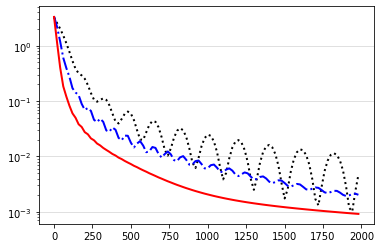

In [23]:
# plot reward values

f_value = plt.figure

num_every = 20
num_grads = np.arange(0, total_iterates, num_every)

# case #1
reward_value_ReLOAD_1 = np.array(reward_value_ReLOAD_1)
error_reward_value_ReLOAD_1 = np.absolute(reward_value_ReLOAD_1 + res.fun)

# case #2
reward_value_ReLOAD_2 = np.array(reward_value_ReLOAD_2)
error_reward_value_ReLOAD_2 = np.absolute(reward_value_ReLOAD_2 + res.fun)

# case #3
reward_value_ReLOAD_3 = np.array(reward_value_ReLOAD_3)
error_reward_value_ReLOAD_3 = np.absolute(reward_value_ReLOAD_3 + res.fun)

# convert y-axis to Logarithmic scale
plt.yscale("log")

plt.plot(num_grads,error_reward_value_ReLOAD_1[::num_every], "k:",linewidth=2)
plt.plot(num_grads,error_reward_value_ReLOAD_2[::num_every], "b-.",linewidth=2)
plt.plot(num_grads,error_reward_value_ReLOAD_3[::num_every], "r-",linewidth=2)
plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
get_f_value.savefig('NPG_primal_dual_sensitivity_reward_ReLOAD.png',dpi=300)

plt.show()

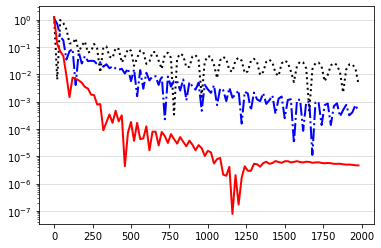

In [24]:
# plot utility values

g_value = plt.figure

num_every = 20
num_grads = np.arange(0, total_iterates, num_every)

# case #1
utility_value_ReLOAD_1 = np.array(utility_value_ReLOAD_1)
error_utility_value_ReLOAD_1 = np.absolute(utility_value_ReLOAD_1)

# case #2
utility_value_ReLOAD_2 = np.array(utility_value_ReLOAD_2)
error_utility_value_ReLOAD_2 = np.absolute(utility_value_ReLOAD_2)

# case #3
utility_value_ReLOAD_3 = np.array(utility_value_ReLOAD_3)
error_utility_value_ReLOAD_3 = np.absolute(utility_value_ReLOAD_3)

# convert y-axis to Logarithmic scale
plt.yscale("log")

plt.plot(num_grads,error_utility_value_ReLOAD_1[::num_every], "k:", linewidth=2)
plt.plot(num_grads,error_utility_value_ReLOAD_2[::num_every], "b-.", linewidth=2)
plt.plot(num_grads,error_utility_value_ReLOAD_3[::num_every], "r-", linewidth=2)
plt.grid(axis='y', color='0.85')
plt.draw()
get_g_value = plt.gcf()
get_g_value.savefig('NPG_primal_dual_sensitivity_utility_ReLOAD.png',dpi=300)

plt.show()

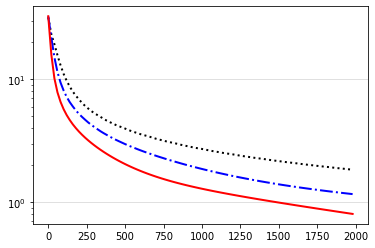

In [25]:
# plot KL distance of policy gap  

p_distance = plt.figure

num_every = 20
num_grads = np.arange(0, total_iterates, num_every)

# case #1
policy_distance_ReLOAD_1 = np.array(policy_distance_ReLOAD_1)

# case #2
policy_distance_ReLOAD_2 = np.array(policy_distance_ReLOAD_2)

# case #3
policy_distance_ReLOAD_3 = np.array(policy_distance_ReLOAD_3)

# convert y-axis to Logarithmic scale
plt.yscale("log")

plt.plot(num_grads,policy_distance_ReLOAD_1[::num_every], "k:", linewidth=2)
plt.plot(num_grads,policy_distance_ReLOAD_2[::num_every], "b-.", linewidth=2)
plt.plot(num_grads,policy_distance_ReLOAD_3[::num_every], "r-", linewidth=2)
plt.grid(axis='y', color='0.85')
plt.draw()
p_distance = plt.gcf()
p_distance.savefig('NPG_primal_dual_squared_policy_distance_ReLOAD.png',dpi=300)

plt.show()